In [ ]:
'''
    Import related libraries'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator, MaxNLocator

import cv2
from skimage import filters, morphology, measure
from google.colab import files
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, LinearLocator, FuncFormatter
from scipy.ndimage import gaussian_filter1d


In [ ]:
'''
   Upload'''
uploaded = files.upload();
file_path = list(uploaded.keys())[0];
sem_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE);

  # Ensure image is uint8//
sem_image = sem_image.astype(np.uint8)

  # Image dimensions//
height_pixels, width_pixels = sem_image.shape; # Extract height and width.
total_pixels = width_pixels * height_pixels;
print(f"Width: {width_pixels}, Height: {height_pixels}, Total Pixels: {total_pixels}");


Saving 4.0.jpg to 4.0 (1).jpg
Width: 654, Height: 656, Total Pixels: 429024


In [ ]:
'''
   Image processing for contour details'''
# Gaussian blur and Otsu thresholding//
blurred = cv2.GaussianBlur(sem_image, (5, 5), 0);
_, binary_image = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU);

# Contour Extraction//
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE); # To find largest contour.
largest_contour = max(contours, key=cv2.contourArea);
print(f"Largest contour area: {cv2.contourArea(largest_contour):.2f}");
print(f"Largest contour has {len(largest_contour)} points");

# Fit circle//
(center_x, center_y), radius = cv2.minEnclosingCircle(largest_contour);
center = (int(center_x), int(center_y));
radius = int(radius);
print(f"Circle center: {center}");
print(f"Circle radius: {radius} px");

# Fit ellipse and align to circle center//
if len(largest_contour) >= 5:
    ellipse = cv2.fitEllipse(largest_contour);
    ellipse = (center, ellipse[1], ellipse[2]); # Override center with circle center.
    print(f"Original ellipse center: ({ellipse[0][0]:.2f}, {ellipse[0][1]:.2f})");
    print(f"Ellipse axes: ({ellipse[1][0]:.2f}, {ellipse[1][1]:.2f})");
    print(f"Ellipse angle: {ellipse[2]:.2f}°");


Largest contour area: 6015.50
Largest contour has 558 points
Circle center: (328, 341)
Circle radius: 165 px
Original ellipse center: (328.00, 341.00)
Ellipse axes: (313.05, 345.59)
Ellipse angle: 15.13°


/tmp/ipython-input-51-2655910521.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=5.0); # Adjust layout to prevent cropping (i.e. Increase padding).
/tmp/ipython-input-51-2655910521.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


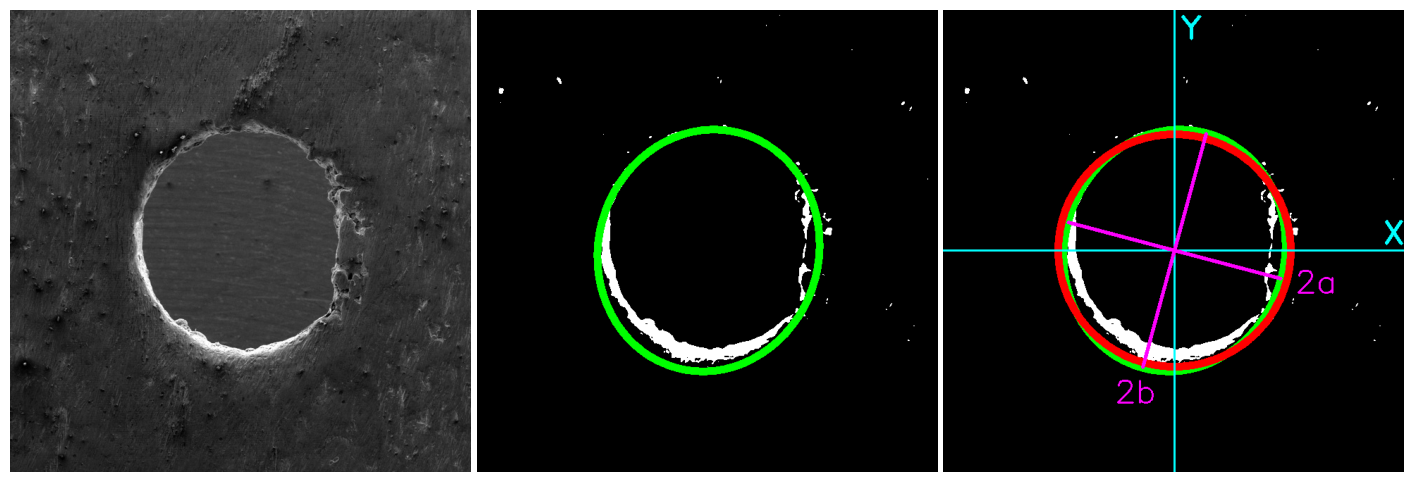

In [ ]:
'''
   --- Prepare images with overlays ---'''

# --- Ellipse ---//
binary_with_ellipse = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR);
cv2.ellipse(binary_with_ellipse, ellipse, (0, 255, 0), 10);

# Axis parameters//
(center_x, center_y), (major_len, minor_len), angle_deg = ellipse; angle_rad = np.radians(angle_deg);
a = major_len / 2; b = minor_len / 2;

# Calculate endpoints of major and minor axes//
x_major = int(a * np.cos(angle_rad)); y_major = int(a * np.sin(angle_rad));
pt1_major = (int(center_x - x_major), int(center_y - y_major)); pt2_major = (int(center_x + x_major), int(center_y + y_major));

x_minor = int(b * np.cos(angle_rad + np.pi / 2)); y_minor = int(b * np.sin(angle_rad + np.pi / 2));
pt1_minor = (int(center_x - x_minor), int(center_y - y_minor)); pt2_minor = (int(center_x + x_minor), int(center_y + y_minor));


# --- Circle ---//
binary_with_both = binary_with_ellipse.copy();
cv2.circle(binary_with_both, center, radius, (255, 0, 0), 10);

binary_annotated = binary_with_both.copy(); # Copy and annotate clean image//

'''
   --- Plot images ---'''
# Draw X and Y coordinate axes//
cv2.line(binary_annotated, (0, center[1]), (binary_annotated.shape[1], center[1]), (0, 255, 255), 2); # X axis.
cv2.line(binary_annotated, (center[0], 0), (center[0], binary_annotated.shape[0]), (0, 255, 255), 2); # Y axis.

cv2.putText(binary_annotated, "X", (binary_annotated.shape[1] - 30, center[1] - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 255), 4);
cv2.putText(binary_annotated, "Y", (center[0] + 10, 40),
            cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 255), 4);

# Draw major and minor axes//
cv2.line(binary_annotated, pt1_major, pt2_major, (255, 0, 255), 4); # Major axis.
cv2.line(binary_annotated, pt1_minor, pt2_minor, (255, 0, 255), 4); # Minor axis.

# Label the ends of axes//
# Offset label positions for better visibility.
offset_a = (20, 20); # Right & up.
offset_b = (-40, 50); # Left & down.

pt2_major_label = (pt2_major[0] + offset_a[0], pt2_major[1] + offset_a[1]);
pt2_minor_label = (pt2_minor[0] + offset_b[0], pt2_minor[1] + offset_b[1]);

# Draw axis labels with improved positioning//
cv2.putText(binary_annotated, "2a", pt2_major_label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 255), 2);
cv2.putText(binary_annotated, "2b", pt2_minor_label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 255), 2);

# === Plot results ===//
fig, axs = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'wspace': 0.01});

axs[0].imshow(sem_image, cmap='gray');
#axs[0].set_title("Original SEM Image");
axs[0].axis('off');

axs[1].imshow(binary_with_ellipse);
#axs[1].set_title("Binary Image with Fitted Ellipse");
axs[1].axis('off');

axs[2].imshow(binary_annotated);
#axs[2].set_title("Binary Image with Circle, Ellipse, Axes, and Labels");
axs[2].axis('off');

# Save and download the plot//
file_name = "Trap hole.svg";
plt.tight_layout(pad=5.0); # Adjust layout to prevent cropping (i.e. Increase padding).
plt.savefig(file_name, format="svg", bbox_inches='tight'); # bbox_inches='tight' to prevent cutting off.
#files.download(file_name); # Download.

plt.tight_layout();
plt.show();


In [ ]:
'''
   --- Ellipticity ---'''
# CAD file true hole diameter is 2.0 mm//
diameter_px = 2 * radius; # Fitted circle from image gives diameter in pixels.

scale_mm_per_px = 2.0 / diameter_px; # Conversion scale [mm per pixel].
print(f"Scale factor: {scale_mm_per_px:.4f} mm per pixel");

# Convert to mm//
a_mm = a * scale_mm_per_px; # Semi-major axis in pixels.
print(f"Semi-major axis a ≈ {a_mm:.4f} mm");

b_mm = b * scale_mm_per_px; # Semi-minor axis in pixels.
print(f"Semi-minor axis b ≈ {b_mm:.4f} mm");

modulus_ellipticity = abs((a_mm - b_mm) / (a_mm + b_mm)); # Calculate ellipticity.
print(f"Modulus of Ellipticity |ε| = |(a - b)/(a + b)| ≈ {modulus_ellipticity:.4f}");


Scale factor: 0.0061 mm per pixel
Semi-major axis a ≈ 0.9486 mm
Semi-minor axis b ≈ 1.0472 mm
Modulus of Ellipticity |ε| = |(a - b)/(a + b)| ≈ 0.0494
